In [98]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import sys
from pathlib import Path
import os
sys.path.append('../')

In [100]:
ROOT = "/Users/louislacombe/Thesis_code/yolov5/"
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative


LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))

In [112]:
import yaml
import datetime
from tqdm import tqdm
import argparse
import json

import numpy as np
import torch

from utils.general import split_dict

from utils.calibration_utils import (
    setup_data_model, get_yolo_predictions, get_data_pred, calib_prep, collect_data_obj, 
    fitting_obj_calibrators, predict_obj_conf, draw_reliability_graph, 
    create_pred_for_nms, NMS, calibration,
    collect_data_class, fitting_class_calibrators, predict_class_conf,
    )

from sklearn.isotonic import IsotonicRegression


In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

# Calibration

In [104]:
opt = '../config/opt/opt_Visdrone_detect_S_Hyp0.yaml'
dataloader, model, opt, device, dt = setup_data_model(opt, ROOT)
num_classes = model.model.nc

data_dict = get_yolo_predictions(dataloader, model, opt, device, dt)
calib_dict, test_dict = split_dict(data_dict, (0.3, 0.7))
print("Length calib dict: ", len(calib_dict), " and length calib dict: ", len(test_dict))

YOLOv5 🚀 v6.2-197-g124a787 Python-3.10.6 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/Users/louislacombe/Thesis_code/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache' images and labels... 1610 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 51/51 [11:13<00:00, 13.21s/it]

Length calib dict:  15  and length calib dict:  36


In [105]:
# Calibration parameters:
n_bins = 50
conf_thres = 0.01
iou_thres_obj = 0.6
iou_thres_class = 0.3

where_apply_calib_obj = "pred"
where_apply_calib_class = "after_nms"

# Choose which calibrator you want to use for the calibration
# calibrator = HistogramBinning(n_bins) # Histogram binning
# calibrator = _SigmoidCalibration() # Platt
calibrator = IsotonicRegression(out_of_bounds="clip") # Isotonic Regression


In [106]:
print("BEFORE NMS")
calib_location = "pred"
calib_obj = (where_apply_calib_obj == calib_location)
calib_class = (where_apply_calib_class == calib_location)

calibration(
    calib_location,
    calib_obj,
    calib_class,
    calib_dict,
    test_dict,
    calibrator,
    conf_thres,
    iou_thres_obj,
    iou_thres_class,
    dataloader,
    opt,
    num_classes,
    device
)

print("-"*50)
print("-"*50)
print("AFTER NMS")
calib_location = "after_nms"
calib_obj = (where_apply_calib_obj == calib_location)
calib_class = (where_apply_calib_class == calib_location)

calibration(
    calib_location,
    calib_obj,
    calib_class,
    calib_dict,
    test_dict,
    calibrator,
    conf_thres,
    iou_thres_obj,
    iou_thres_class,
    dataloader,
    opt,
    num_classes,
    device
)


BEFORE NMS


100%|██████████| 36/36 [00:01<00:00, 24.72it/s]


calib obj
running NMS
nms calib


100%|██████████| 51/51 [00:06<00:00,  8.17it/s]


nms test


100%|██████████| 51/51 [00:08<00:00,  6.35it/s]


--------------------------------------------------
--------------------------------------------------
AFTER NMS


100%|██████████| 36/36 [00:00<00:00, 247.47it/s]


calib class


In [110]:
obj_true = []
obj_normal = []
obj_calib = []

for path in test_dict:
    values_ = test_dict[path]
    if "idx" in values_.keys():
        obj_true.extend(values_["pred_obj_y_true"])
        obj_calib.extend(values_["pred_calib_obj_score"])
        obj_normal.extend(values_["pred_obj_score_idx"])


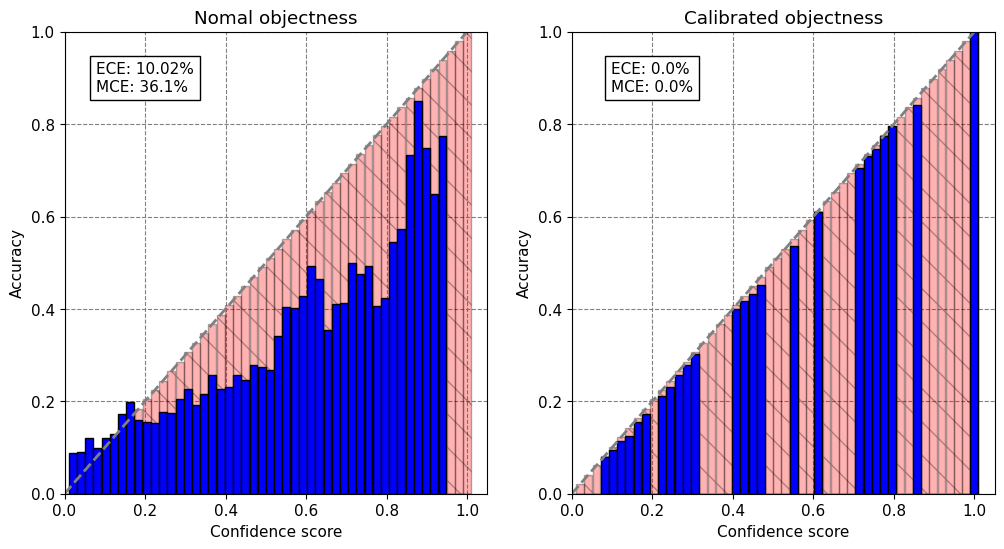

In [111]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
draw_reliability_graph(np.array(obj_normal), np.array(obj_true), n_bins, strategy="uniform", title="Nomal objectness", axs=axs1)
draw_reliability_graph(np.array(obj_calib), np.array(obj_true), n_bins, strategy="uniform", title="Calibrated objectness", axs=axs2)
plt.show()

In [109]:
# Configure
model.eval()
iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

seen = 0
confusion_matrix = ConfusionMatrix(nc=nc)
if isinstance(names, (list, tuple)):  # old format
    names = dict(enumerate(names))
class_map = list(range(1000))
s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
jdict, stats, ap, ap_class = [], [], [], []


NameError: name 'ConfusionMatrix' is not defined